In [ ]:
# Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC  # Import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.calibration import CalibratedClassifierCV # Import CalibratedClassifierCV


import xgboost as xgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, Activation

In [ ]:
# Load Dataset ---
try:
    reviews_data = pd.read_csv('/content/drive/MyDrive/Google Play Reviews.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset not found. Please check the file path.")
    exit()

Dataset loaded successfully.


In [ ]:
# Preprocess Dataset ---
reviews_data = reviews_data[['content', 'score']].dropna()
reviews_data = reviews_data[reviews_data['score'] != 3]
reviews_data['sentiment'] = reviews_data['score'].apply(lambda x: 'positive' if x > 3 else 'negative')

X = reviews_data['content']
y = reviews_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Feature Extraction ---
count_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_count = count_vectorizer.fit_transform(X_train).toarray()
X_test_count = count_vectorizer.transform(X_test).toarray()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [ ]:
# Helper Function ---
model_scores = {}
all_fpr = {}
all_tpr = {}
all_auc = {}

In [ ]:
# Naïve Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_count, y_train)
y_pred_nb = nb_model.predict(X_test_count)
nb_acc = accuracy_score(y_test, y_pred_nb)
model_scores["Naïve Bayes"] = nb_acc * 100
print("\nNaïve Bayes Accuracy: {:.2f}%".format(nb_acc * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=['negative', 'positive']), nb_model.predict_proba(X_test_count)[:,1])
all_fpr['Naïve Bayes'] = fpr
all_tpr['Naïve Bayes'] = tpr
all_auc['Naïve Bayes'] = auc(fpr, tpr)


Naïve Bayes Accuracy: 83.12%
Confusion Matrix:
[[593 127]
 [116 604]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.82      0.83       720
    positive       0.83      0.84      0.83       720

    accuracy                           0.83      1440
   macro avg       0.83      0.83      0.83      1440
weighted avg       0.83      0.83      0.83      1440



In [ ]:
# Fast SVM with LinearSVC and 10-Fold Cross-Validation ---
base_svm = LinearSVC()
svm_model = CalibratedClassifierCV(base_svm, cv=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
svm_scores = cross_val_score(svm_model, X_train_count, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
print("\nSVM 10-Fold Cross-Validation Accuracy: {:.2f}% (+/- {:.2f}%)".format(svm_scores.mean() * 100, svm_scores.std() * 100))
svm_model.fit(X_train_count, y_train)
y_pred_svm = svm_model.predict(X_test_count)
svm_acc = accuracy_score(y_test, y_pred_svm)
model_scores["SVM"] = svm_acc * 100
print("\nSVM Accuracy: {:.2f}%".format(svm_acc * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=['negative', 'positive']), svm_model.predict_proba(X_test_count)[:,1])
all_fpr['SVM'] = fpr
all_tpr['SVM'] = tpr
all_auc['SVM'] = auc(fpr, tpr)


SVM 10-Fold Cross-Validation Accuracy: 85.52% (+/- 1.50%)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



SVM Accuracy: 83.89%
Confusion Matrix:
[[579 141]
 [ 91 629]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.80      0.83       720
    positive       0.82      0.87      0.84       720

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [ ]:
# Bi-LSTM with Activation Functions ---
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
y_train_binary = np.where(y_train == 'positive', 1, 0)
y_test_binary = np.where(y_test == 'positive', 1, 0)

bi_lstm_model = Sequential([
    Embedding(5000, 50, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Activation('relu'),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Activation('tanh'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bi_lstm_model.fit(X_train_pad, y_train_binary, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_binary), verbose=1)
bi_lstm_acc = bi_lstm_model.evaluate(X_test_pad, y_test_binary, verbose=0)[1]
model_scores["Bi-LSTM"] = bi_lstm_acc * 100

fpr, tpr, _ = roc_curve(y_test_binary, bi_lstm_model.predict(X_test_pad))
all_fpr['Bi-LSTM'] = fpr
all_tpr['Bi-LSTM'] = tpr
all_auc['Bi-LSTM'] = auc(fpr, tpr)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step - accuracy: 0.6219 - loss: 0.6414 - val_accuracy: 0.8049 - val_loss: 0.4344
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.8516 - loss: 0.3661 - val_accuracy: 0.8403 - val_loss: 0.3694
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.8827 - loss: 0.2999 - val_accuracy: 0.8257 - val_loss: 0.4058
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.9169 - loss: 0.2297 - val_accuracy: 0.8354 - val_loss: 0.3719
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.9459 - loss: 0.1771 - val_accuracy: 0.8458 - val_loss: 0.3949
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [ ]:
# Logistic Regression ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, y_pred_lr)
model_scores["Logistic Regression"] = lr_acc * 100
print("\nLogistic Regression Accuracy: {:.2f}%".format(lr_acc * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=['negative', 'positive']), lr_model.predict_proba(X_test_tfidf)[:,1])
all_fpr['Logistic Regression'] = fpr
all_tpr['Logistic Regression'] = tpr
all_auc['Logistic Regression'] = auc(fpr, tpr)


Logistic Regression Accuracy: 84.79%
Confusion Matrix:
[[615 105]
 [114 606]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85       720
    positive       0.85      0.84      0.85       720

    accuracy                           0.85      1440
   macro avg       0.85      0.85      0.85      1440
weighted avg       0.85      0.85      0.85      1440



In [ ]:
# Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, y_pred_rf)
model_scores["Random Forest"] = rf_acc * 100
print("\nRandom Forest Accuracy: {:.2f}%".format(rf_acc * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=['negative', 'positive']), rf_model.predict_proba(X_test_tfidf)[:,1])
all_fpr['Random Forest'] = fpr
all_tpr['Random Forest'] = tpr
all_auc['Random Forest'] = auc(fpr, tpr)


Random Forest Accuracy: 84.10%
Confusion Matrix:
[[640  80]
 [149 571]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.89      0.85       720
    positive       0.88      0.79      0.83       720

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [ ]:
# XGBoost ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test_tfidf)
xgb_acc = accuracy_score(y_test_enc, y_pred_xgb)
model_scores["XGBoost"] = xgb_acc * 100
print("\nXGBoost Accuracy: {:.2f}%".format(xgb_acc * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test_enc, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test_enc, y_pred_xgb))

fpr, tpr, _ = roc_curve(y_test_enc, xgb_model.predict_proba(X_test_tfidf)[:,1])
all_fpr['XGBoost'] = fpr
all_tpr['XGBoost'] = tpr
all_auc['XGBoost'] = auc(fpr, tpr)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:25:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 83.68%
Confusion Matrix:
[[594 126]
 [109 611]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       720
           1       0.83      0.85      0.84       720

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



<ipython-input-17-44234f931fbf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="Set2")


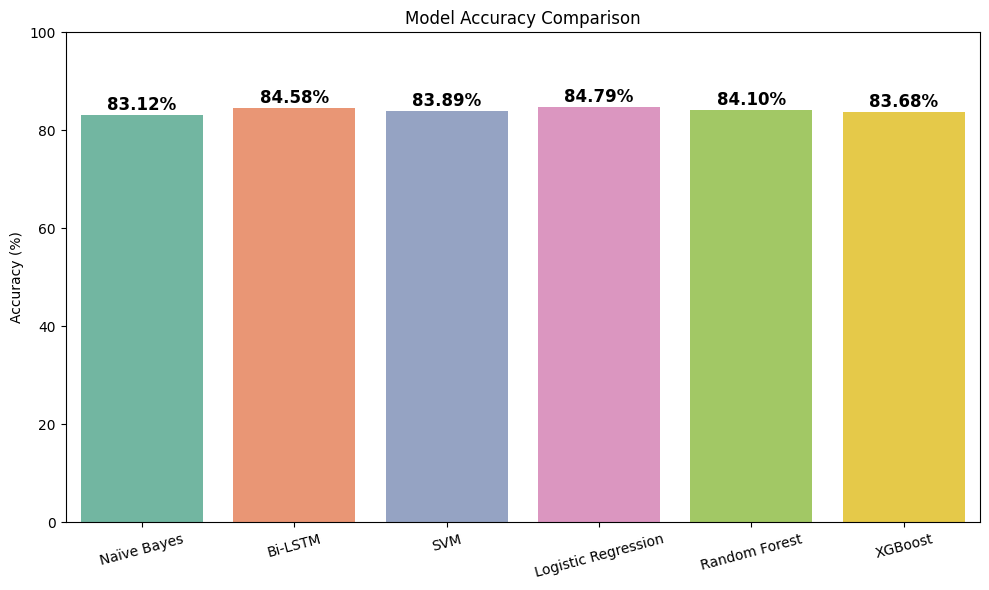

In [ ]:
# Accuracy Comparison Plot ---
plt.figure(figsize=(10, 6))
model_names = list(model_scores.keys())
accuracies = list(model_scores.values())
sns.barplot(x=model_names, y=accuracies, palette="Set2")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12, fontweight='bold')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

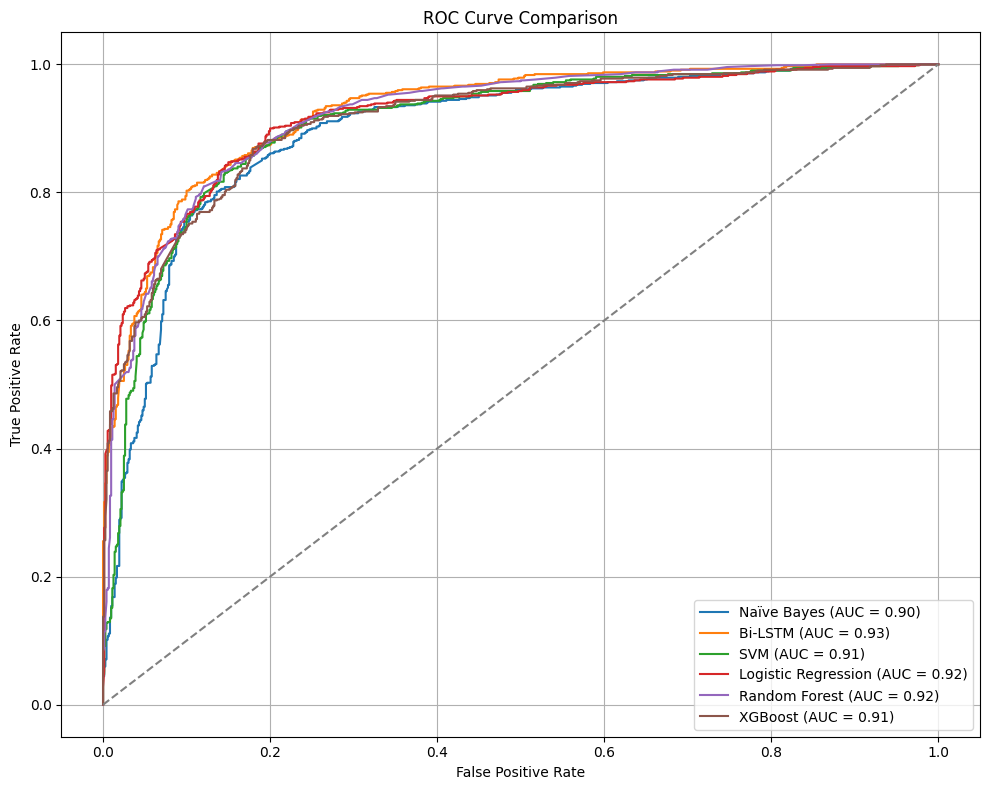

In [ ]:
# ROC Curve Plot ---
plt.figure(figsize=(10, 8))
for model in all_fpr:
    plt.plot(all_fpr[model], all_tpr[model], label=f"{model} (AUC = {all_auc[model]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()